In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [35]:
# Load our data for training models
train_data = pd.read_csv("Data/train.csv")

In [36]:
#Take a look at what we see.
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


It's pretty obvious here that there are a lot of 'NaN' values in some of these columns. For things like PoolQC and PoolArea, it might be that there was only a value entered if the house had a pool. Other columns like MiscFeature may have less value, but let's do some EDA to make that call.  

Looking at the metadata, that seems to be the case. NaN is not missing data, but means there is no pool and many other columns have a similar layout. There seem to be no codes that are simply 'No', so I will replace NaN with 'No' and deal with it as a factor.

### Numerical variables

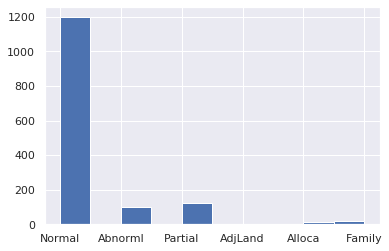

In [118]:
train_data['SaleCondition'].hist()
#Immediately it seems that maybe we don't want to include abnormal or partial sales in our training data

train_data = train_data[train_data['SaleCondition'] != 'Abnorml']

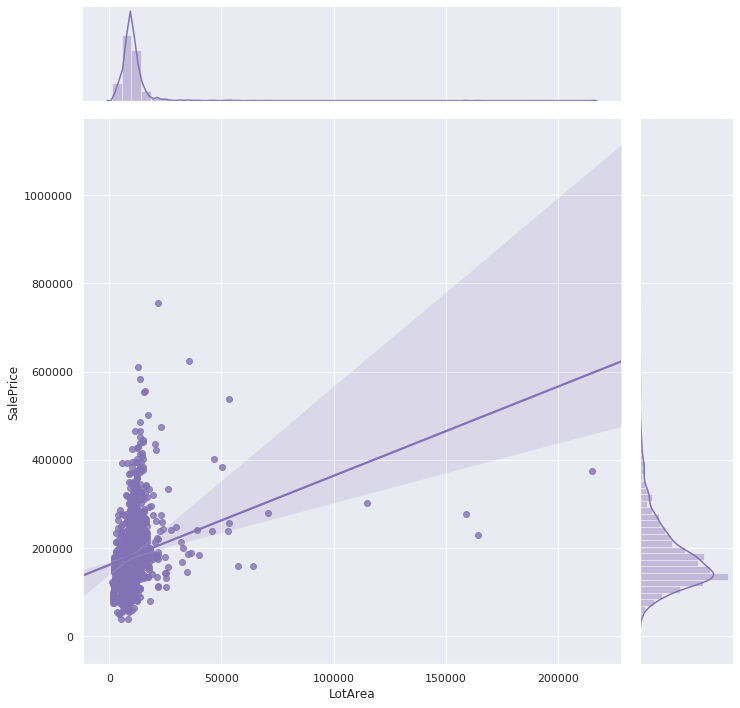

In [119]:
# Let's take a real brief look at some of the likely candidates for driving housing prices
sns.set(style="darkgrid")
g = sns.jointplot("LotArea", "SalePrice", data=train_data, kind="reg",
                   color="m", height=10)


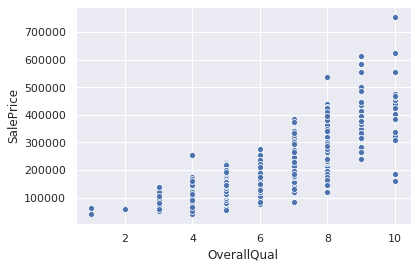

In [120]:
sns.set(style="darkgrid")
g = sns.scatterplot("OverallQual", "SalePrice", data=train_data)

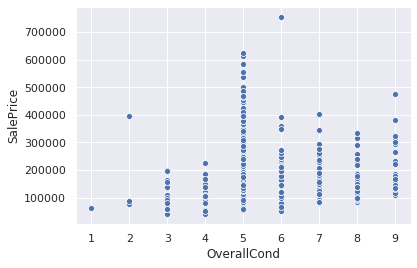

In [121]:
sns.set(style="darkgrid")
g = sns.scatterplot("OverallCond", "SalePrice", data=train_data)

Well already there are some interesting things here. In looking at the relation between square footage and sales price, it looks like there are some outliers in square footage that throw things off. Let's reexamine the relationship after we remove extreme outliers.

In [122]:
print('cut-off: {}'.format(np.percentile(train_data['LotArea'],99)))

cut-off: 39519.800000000076


In [123]:
train_data_sub = train_data[train_data['LotArea'] < np.percentile(train_data['LotArea'],99)]

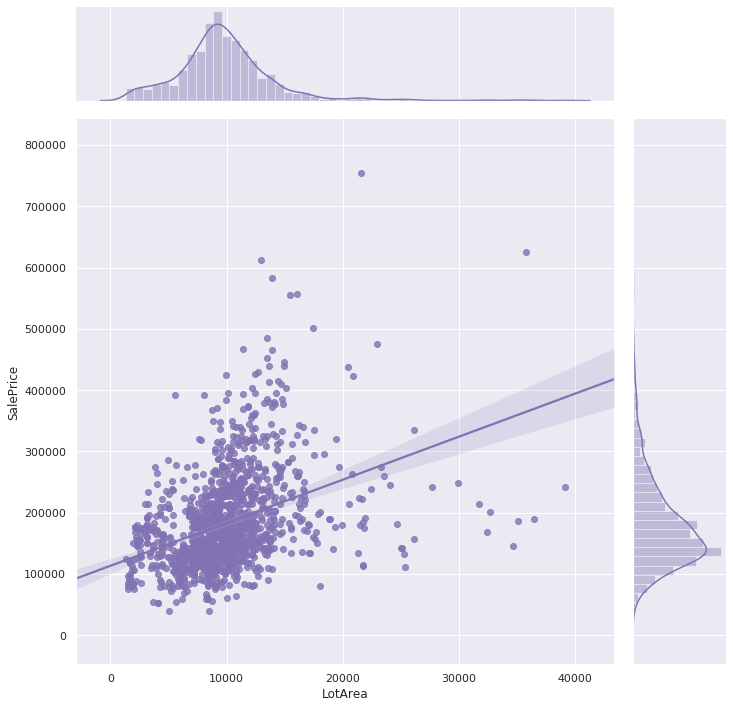

In [124]:
g = sns.jointplot("LotArea", "SalePrice", data=train_data_sub, kind="reg",
                   color="m", height=10)

While this won't let us use only one variable to predict Sale Price, this looks a lot better than previously!

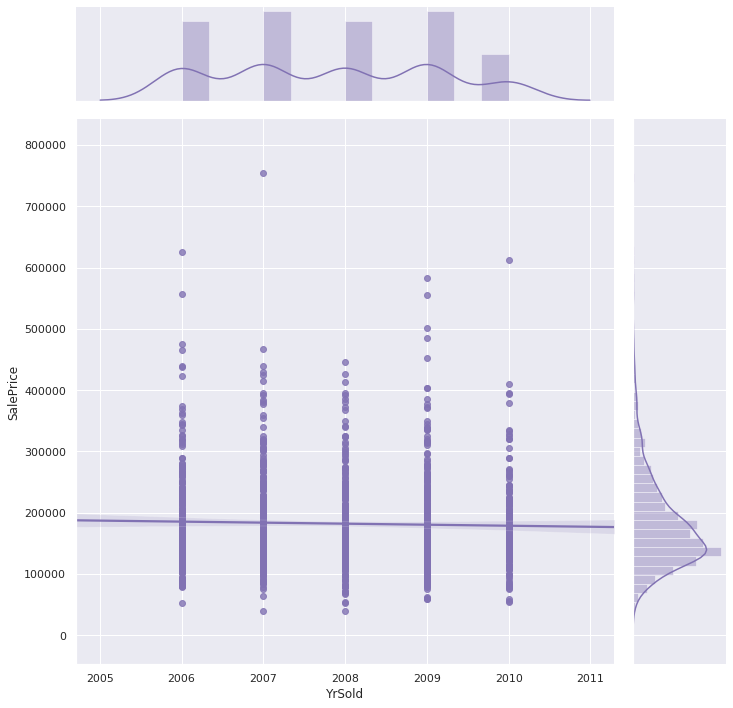

In [125]:
g = sns.jointplot("YrSold", "SalePrice", data=train_data_sub, kind="reg",
                   color="m", height=10)

Although a terrible predictor, at least this can let us go forward and drop a column!

In [126]:
train_data_sub = train_data_sub.drop(columns=['YrSold'])

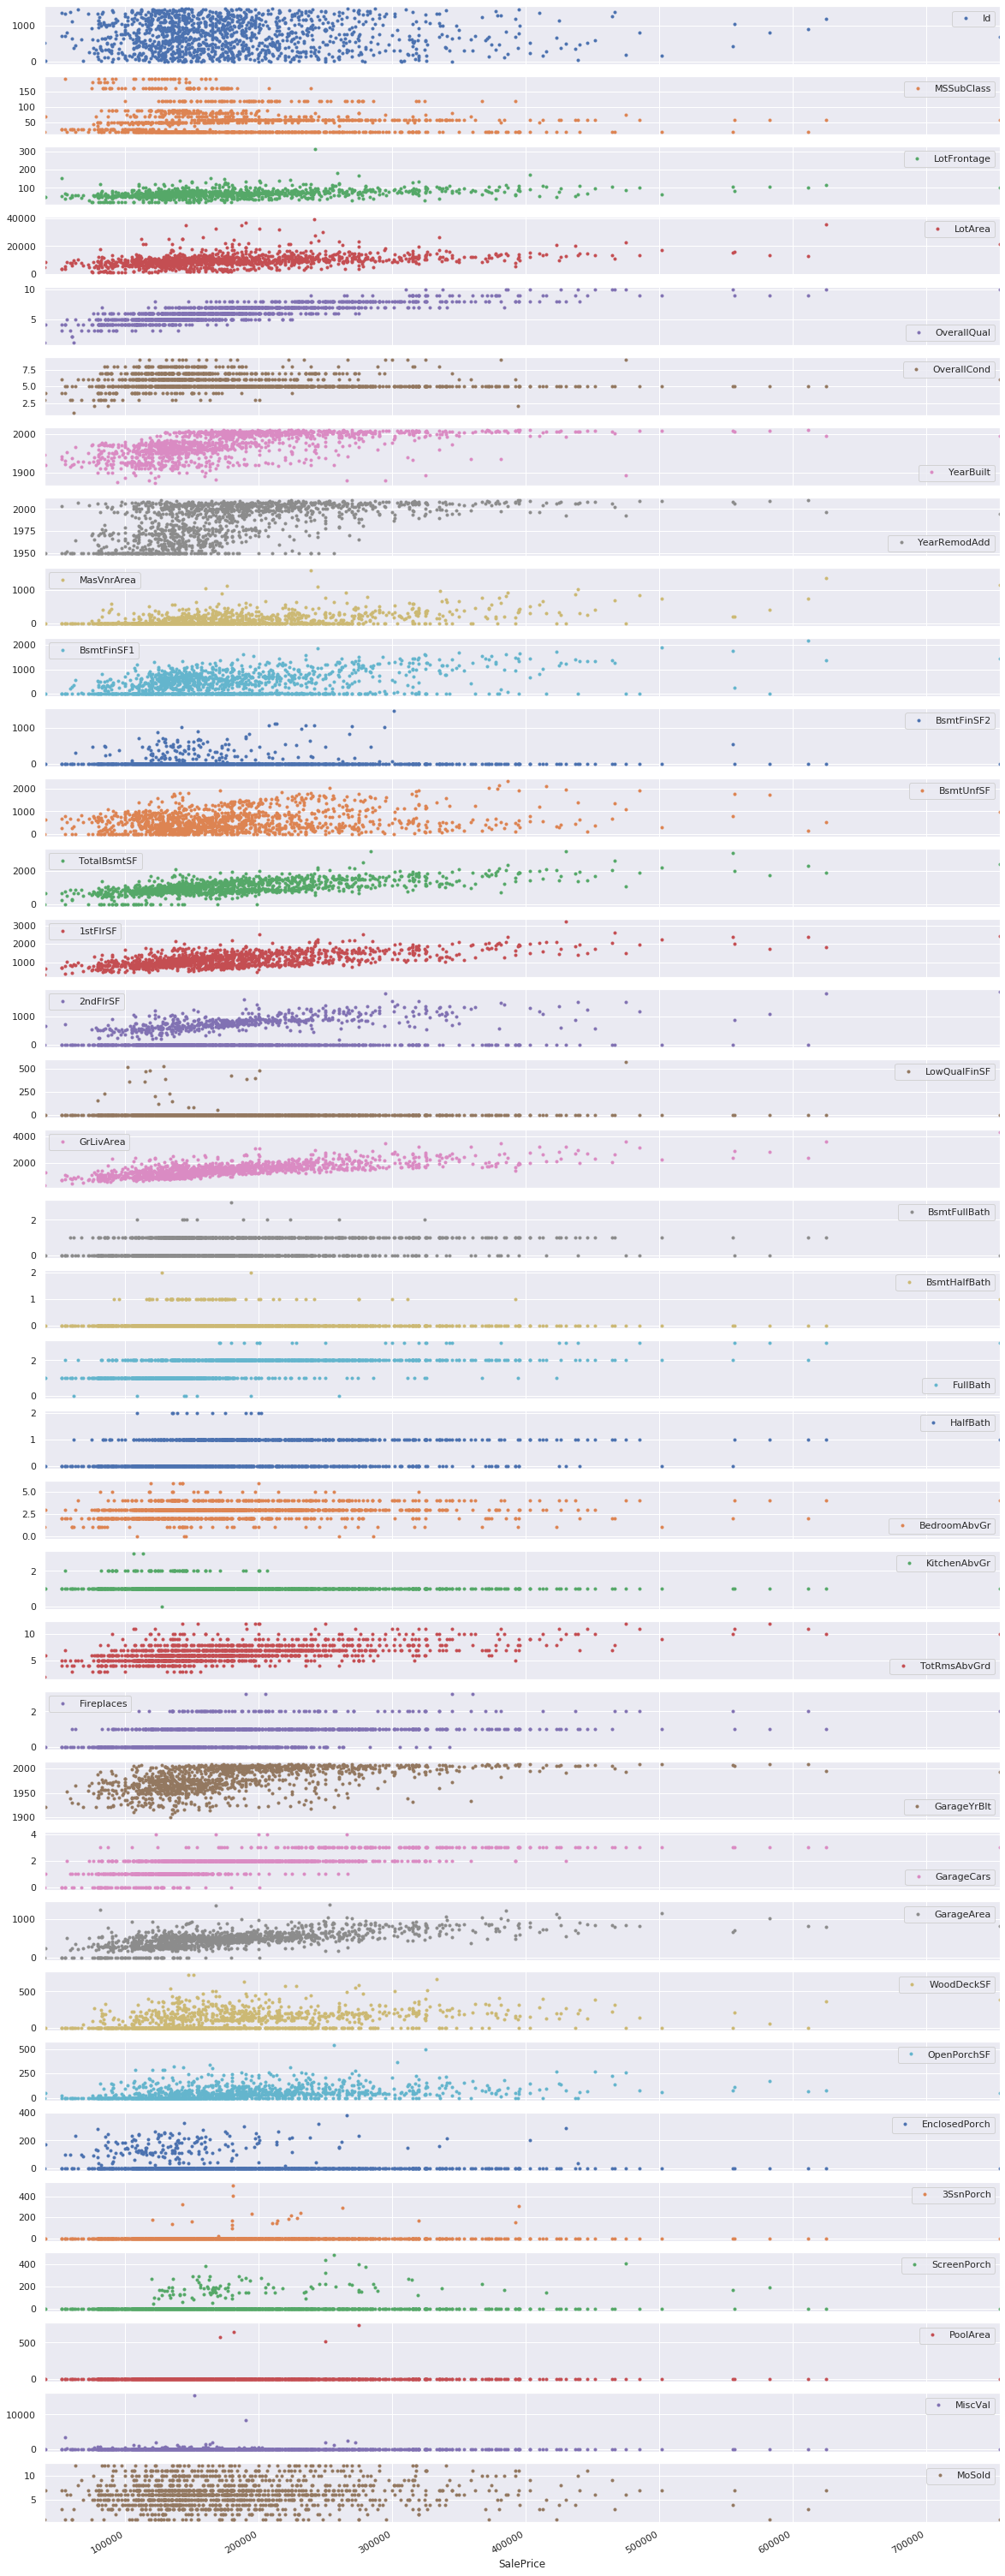

In [127]:
# I need to kick it up a notch here, but if I try to look dataset wide I will destroy my laptop, so I'll do it in slices


col = 'SalePrice'
df2 = train_data_sub.drop(col,axis=1)
df2.index = train_data_sub[col]
df2.plot(subplots=True, style='.')
plt.legend(loc='best')
fig = plt.gcf()
fig.set_size_inches(20, 60)
plt.show()

OK, so that's a lot to parse, but let's make a list of variables that seem at least to have any trend at all!
- LotArea
- MSSubClass (Maybe)
- LotFrontage
- OverallQual (Strong)
- OverallCond (Maybe)
- YearBuilt (Strong)
- Year RemodAdd
- TotalBsmtSF (Strong)
- 1stFlrSF (Strong)
- 2ndFlrSF (Weaker)
- GrLivArea (Strong)
- FullBath
- TotRmsAbvGrd (Strong)
- Fireplaces
- GarageCars
- GarageArea (Strong)
- GarageYrBlt

These are just the numerical variables, but let's start here

Ok, well that reduces the number of variables nicely. Let's subset the dataframe and check to make sure none of the variables are strongly correlated. We want to avoid multi-colinearity issues when we give linear regression a shot.

In [128]:
train_data_reduced = train_data_sub[['LotArea','LotFrontage','MSSubClass','OverallCond','OverallQual','YearBuilt','YearRemodAdd',
                                    'TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','FullBath','TotRmsAbvGrd',
                                    'Fireplaces','GarageCars','GarageYrBlt','GarageArea','SalePrice']].copy()

/home/ben/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ben/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


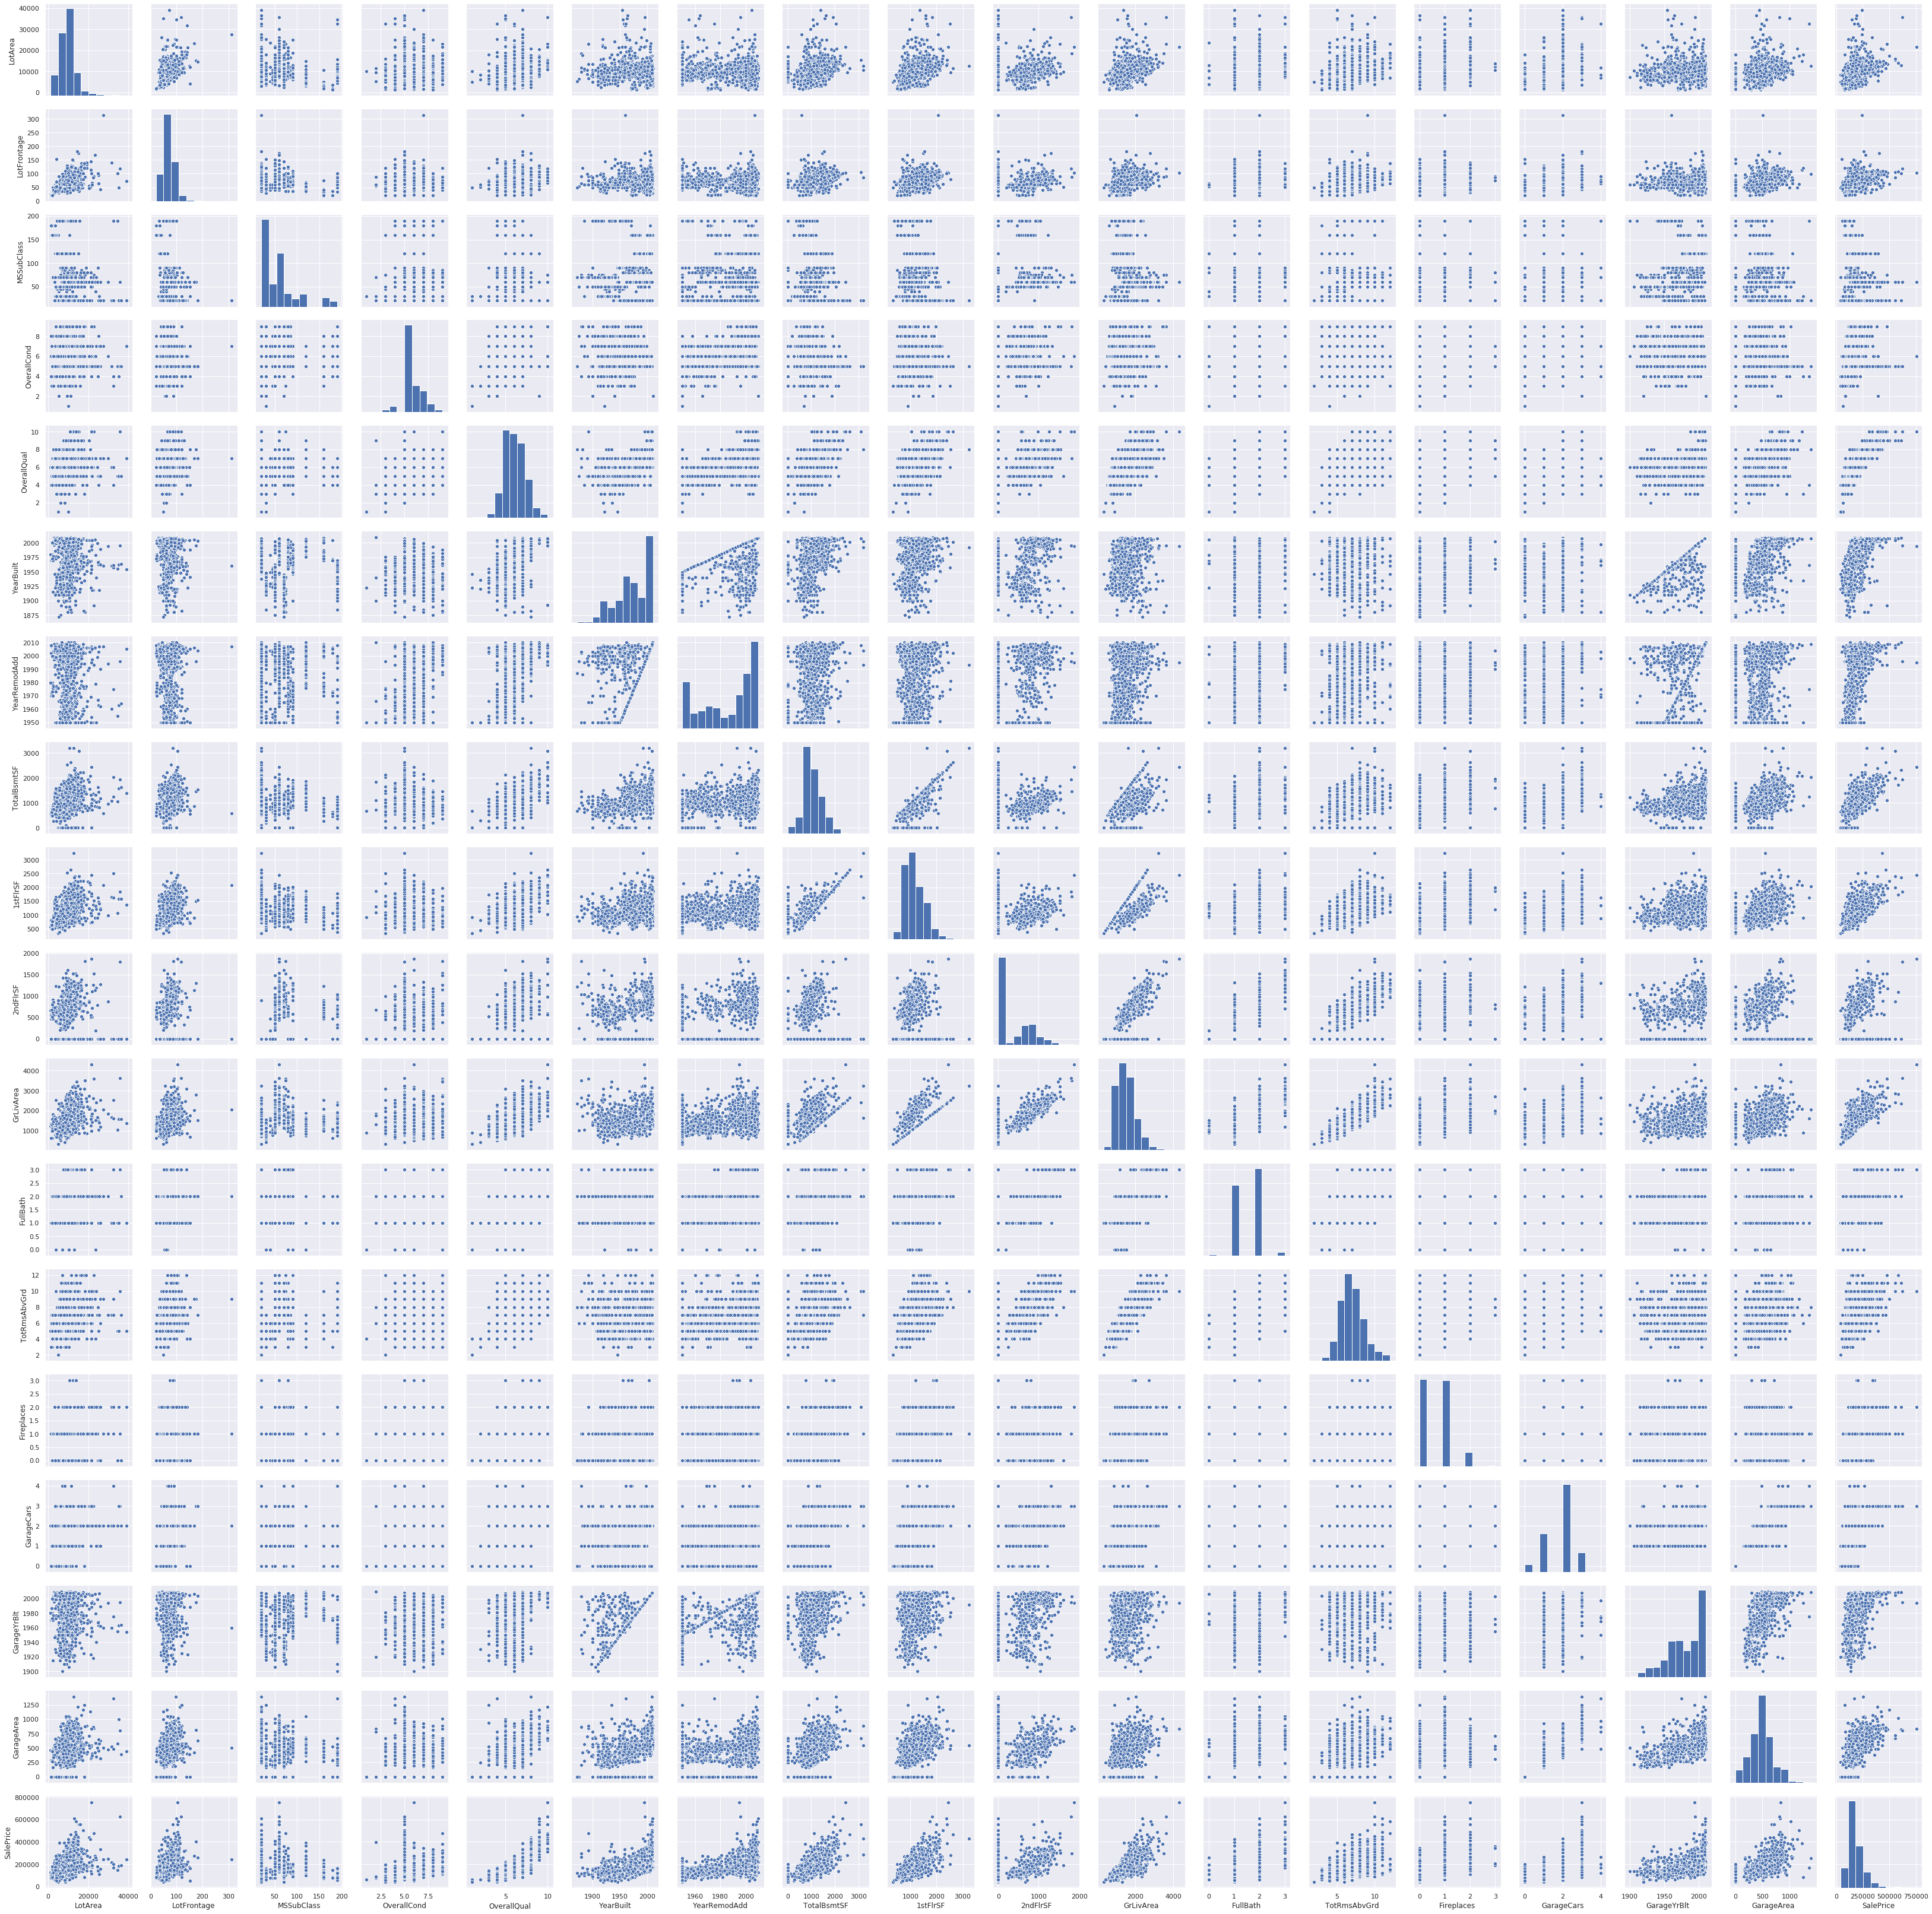

In [129]:
 g = sns.pairplot(train_data_reduced)

### Categorical variables

In [46]:
categorical = train_data_sub.select_dtypes(include='object')

In [47]:
categorical

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


Let's convert the categorical variables. I won't stress ordinality too much as I want to stick with tree-based methods.

In [51]:
categorical = categorical.astype('category')

In [52]:
categorical = categorical.apply(lambda x: x.cat.codes)

In [61]:
joined_data = train_data_reduced.join(categorical)
joined_data = joined_data.fillna(0)

In [69]:
joined_data

,LotArea,MSSubClass,OverallCond,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,8450,60,5,7,2003,2003,856,856,854,1710,...,1,1,4,4,2,-1,-1,-1,8,4
1,9600,20,8,6,1976,1976,1262,1262,0,1262,...,1,1,4,4,2,-1,-1,-1,8,4
2,11250,60,5,7,2001,2002,920,920,866,1786,...,1,1,4,4,2,-1,-1,-1,8,4
3,9550,70,5,7,1915,1970,756,961,756,1717,...,5,2,4,4,2,-1,-1,-1,8,0
4,14260,60,5,8,2000,2000,1145,1145,1053,2198,...,1,1,4,4,2,-1,-1,-1,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,60,5,6,1999,2000,953,953,694,1647,...,1,1,4,4,2,-1,-1,-1,8,4
1456,13175,20,6,6,1978,1988,1542,2073,0,2073,...,1,2,4,4,2,-1,2,-1,8,4
1457,9042,70,9,7,1941,2006,1152,1188,1152,2340,...,1,1,4,4,2,-1,0,2,8,4
1458,9717,20,6,5,1950,1996,1078,1078,0,1078,...,1,2,4,4,2,-1,-1,-1,8,4


In [62]:
target = joined_data['SalePrice']
train_data_vars = joined_data.drop(columns=['SalePrice'])

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data_vars, target, test_size=0.33)

#Let's not get too crazy and just start with default params.
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

print('RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_test,y_pred))))

RMSLE: 0.15178334960067982


/home/ben/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


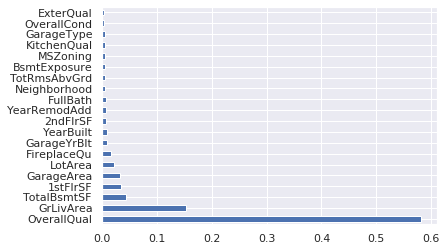

In [70]:
feat_imp = pd.Series(rf.feature_importances_,index=train_data_vars.columns)
feat_imp.nlargest(20).plot(kind="barh")

In [96]:
#Ok let's try a model with the top 20 features then
train_data_imp = joined_data[['OverallQual','GrLivArea','TotalBsmtSF','1stFlrSF','GarageArea','LotArea','FireplaceQu','GarageYrBlt',
                  'YearBuilt','2ndFlrSF','YearRemodAdd']].copy()

In [97]:
X_train, X_test, y_train, y_test = train_test_split(train_data_reduced.drop(columns=['SalePrice']), target, test_size=0.33)

from xgboost import XGBRegressor
#Let's not get too crazy and just start with default params.
xg = XGBRegressor()
xg.fit(X_train,y_train)

y_pred = xg.predict(X_test)

print('RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_test,y_pred))))

[17:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE: 0.15569484314068827


/home/ben/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


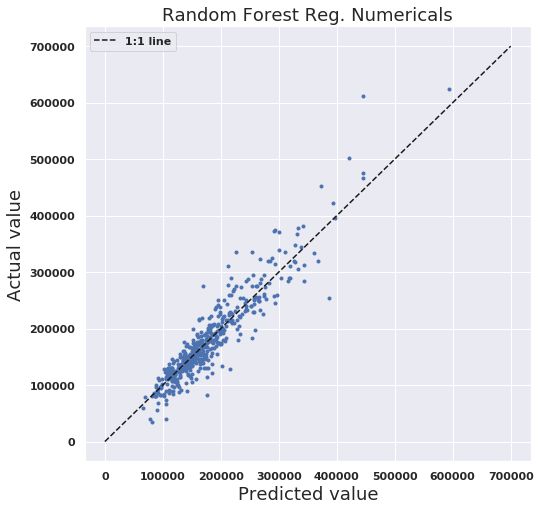

In [46]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 25}

plt.rc('font', **font)

plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

x = np.linspace(0,700000,1000)
y = np.linspace(0,700000,1000)
fig= plt.figure(figsize=(8,8))
plt.plot(y_pred,y_test,'.')
plt.plot(x,y,'--k',label = '1:1 line')
plt.title('Random Forest Reg. Numericals')
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.legend()
plt.show()

The competition metric is root mean square log error and the top test submission score is approx. 0.07. Let's check how we do submitting predictions based on this simple model.

In [90]:
test_data = pd.read_csv('Data/test.csv')

In [91]:
#Keep id's for the sample submission
Id = test_data['Id']
test_data_sub = test_data[['LotArea','MSSubClass','OverallCond','OverallQual','YearBuilt','YearRemodAdd',
                                    'TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','FullBath','TotRmsAbvGrd',
                                    'Fireplaces','GarageCars','GarageYrBlt','GarageArea']].copy()

test_data_sub = test_data_sub.fillna(0)
y_pred = xg.predict(test_data_sub)

In [92]:
dict = {'Id':Id,'SalePrice':y_pred}
submission = pd.DataFrame(dict)

In [93]:
submission.to_csv('xg_sub.csv',index=False)
# This gave us a score of 0.167. Not bad, but certainly not tip top.
# Before we expand our number of input variables, let's try adaboost

In [47]:
from sklearn.ensemble import AdaBoostRegressor

X_train, X_test, y_train, y_test = train_test_split(train_data_vars, target, test_size=0.33)

#Let's not get too crazy and just start with default params.
ada = AdaBoostRegressor()
ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_test,y_pred))))

RMSLE: 0.193177471141333


Higher RMSLE on the training data. Not promising, but we could always hope it generalizes better. Let's check it out.

In [49]:
Id = test_data['Id']
test_data_sub = test_data[['LotArea','MSSubClass','OverallCond','OverallQual','YearBuilt','YearRemodAdd',
                                    'TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','FullBath','TotRmsAbvGrd',
                                    'Fireplaces','GarageCars','GarageArea']].copy()

test_data_sub = test_data_sub.fillna(0)
y_pred = ada.predict(test_data_sub)

In [50]:
dict = {'Id':Id,'SalePrice':y_pred}
submission = pd.DataFrame(dict)
submission.to_csv('ada_sub.csv',index=False)
#Ok worse than before, 0.21...
#Time to start incorporating the categorical variables.